# Explore here

In [1]:
!pip install seaborn
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, r2_score, mean_squared_error
from sklearn.model_selection import KFold
import joblib

In [3]:
url = "https://raw.githubusercontent.com/4GeeksAcademy/linear-regression-project-tutorial/main/medical_insurance_cost.csv"
df = pd.read_csv(url)

In [4]:
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


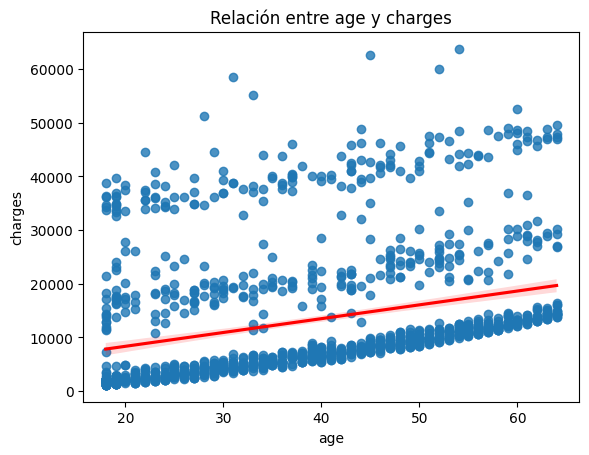

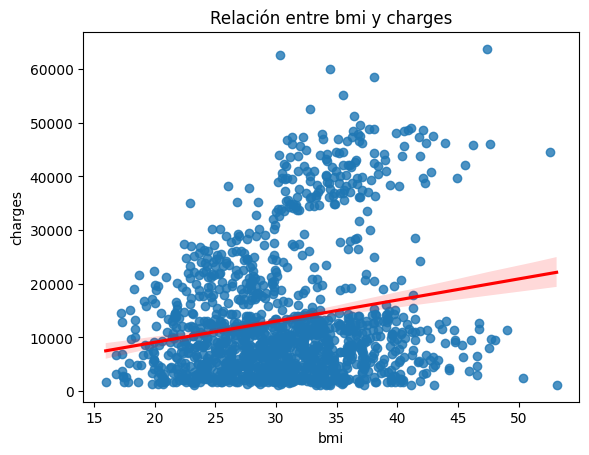

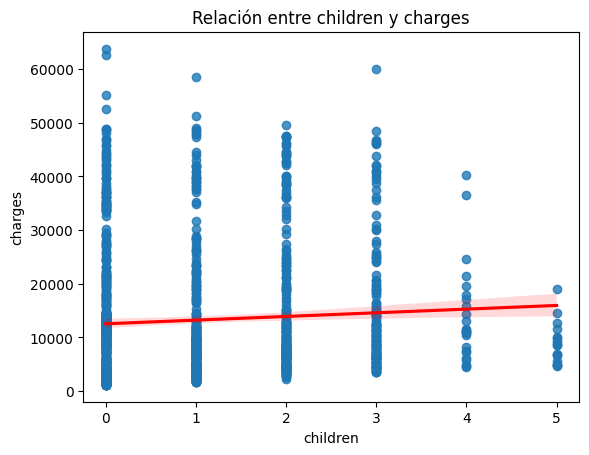

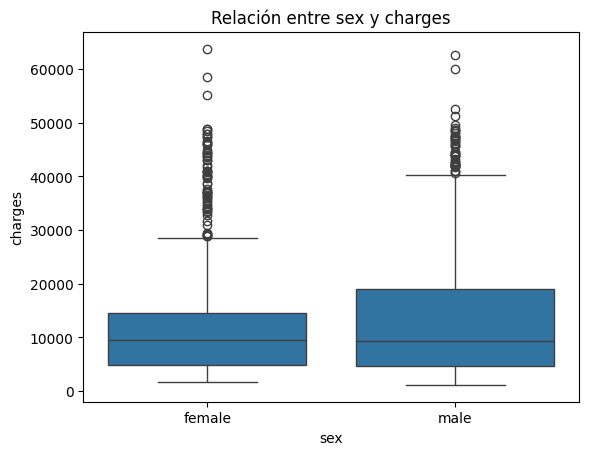

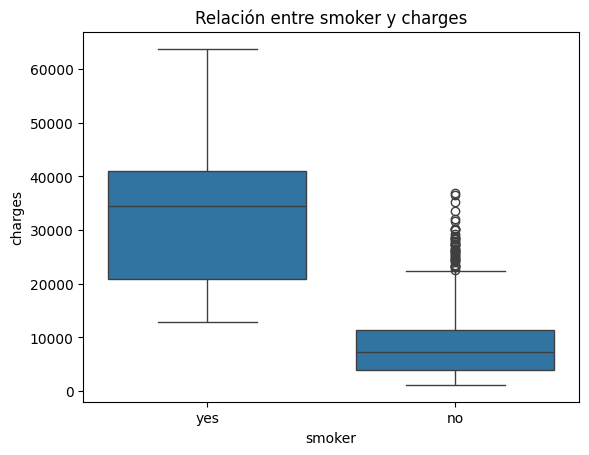

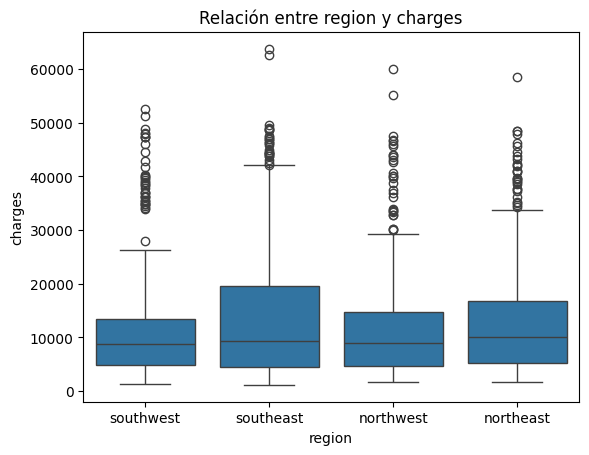

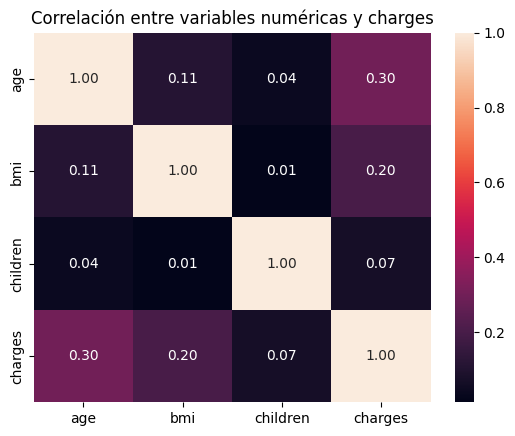

In [6]:
# Variables numéricas: 'age', 'bmi', 'children'
numerical_vars = ['age', 'bmi', 'children']

# Gráficos de dispersión para variables numéricas
for var in numerical_vars:
    sns.regplot(data=df, x=var, y='charges', line_kws={"color": "red"})
    plt.title(f'Relación entre {var} y charges')
    plt.show()

# Boxplots para variables categóricas: 'sex', 'smoker', 'region'
categorical_vars = ['sex', 'smoker', 'region']
for var in categorical_vars:
    sns.boxplot(data=df, x=var, y='charges')
    plt.title(f'Relación entre {var} y charges')
    plt.show()

# Mapa de calor de correlación para variables numéricas
sns.heatmap(df[numerical_vars + ['charges']].corr(), annot=True, fmt=".2f", cbar=True)
plt.title('Correlación entre variables numéricas y charges')
plt.show()

In [7]:
X = df.drop(['charges'], axis=1)
y = df.charges
X, y

(      age     sex     bmi  children smoker     region
 0      19  female  27.900         0    yes  southwest
 1      18    male  33.770         1     no  southeast
 2      28    male  33.000         3     no  southeast
 3      33    male  22.705         0     no  northwest
 4      32    male  28.880         0     no  northwest
 ...   ...     ...     ...       ...    ...        ...
 1333   50    male  30.970         3     no  northwest
 1334   18  female  31.920         0     no  northeast
 1335   18  female  36.850         0     no  southeast
 1336   21  female  25.800         0     no  southwest
 1337   61  female  29.070         0    yes  northwest
 
 [1338 rows x 6 columns],
 0       16884.92400
 1        1725.55230
 2        4449.46200
 3       21984.47061
 4        3866.85520
            ...     
 1333    10600.54830
 1334     2205.98080
 1335     1629.83350
 1336     2007.94500
 1337    29141.36030
 Name: charges, Length: 1338, dtype: float64)

In [8]:
def preprocess_features(df):
    # One-Hot Encoding para variables categóricas
    df_processed = pd.get_dummies(df, columns=['sex', 'smoker', 'region'], drop_first=True)
    
    # Convertir variables booleanas a enteros
    for col in df_processed:
        if df_processed[col].dtype == 'bool':
            df_processed[col] = df_processed[col].astype(int)
    
    # Escalar variables numéricas
    numerical_vars = ['age', 'bmi', 'children']
    scaler = StandardScaler()
    df_processed[numerical_vars] = scaler.fit_transform(df_processed[numerical_vars])
    
    return df_processed, scaler

X, scaler = preprocess_features(X)



In [9]:
X

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,-1.438764,-0.453320,-0.908614,0,1,0,0,1
1,-1.509965,0.509621,-0.078767,1,0,0,1,0
2,-0.797954,0.383307,1.580926,1,0,0,1,0
3,-0.441948,-1.305531,-0.908614,1,0,1,0,0
4,-0.513149,-0.292556,-0.908614,1,0,1,0,0
...,...,...,...,...,...,...,...,...
1333,0.768473,0.050297,1.580926,1,0,1,0,0
1334,-1.509965,0.206139,-0.908614,0,0,0,0,0
1335,-1.509965,1.014878,-0.908614,0,0,0,1,0
1336,-1.296362,-0.797813,-0.908614,0,0,0,0,1


In [10]:
# Crear el modelo de regresión lineal
X = sm.add_constant(X)
model = sm.OLS(y, X)

# Ajustar el modelo a los datos
results = model.fit()

In [11]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     500.8
Date:                Thu, 14 Mar 2024   Prob (F-statistic):               0.00
Time:                        12:50:28   Log-Likelihood:                -13548.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1329   BIC:                         2.716e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             9053.4925    386.149  

### Vamos a estudiar cómo influyen las distintas variables en la multicolinealidad detectada.

In [12]:
# Añadir constante al conjunto de características para el análisis VIF
X_const = add_constant(X)

# Calcular VIF para cada variable
vif = pd.DataFrame()
vif["Variable"] = X_const.columns
vif["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

print(vif)

           Variable       VIF
0             const  5.428992
1               age  1.016822
2               bmi  1.106630
3          children  1.004011
4          sex_male  1.008900
5        smoker_yes  1.012074
6  region_northwest  1.518823
7  region_southeast  1.652230
8  region_southwest  1.529411


### Estos resultados indican dan un VIF adecuado (salvo quizás para el valor de la constante, que se encuentra en el rango 5-10, el cual ya no es tan deseable. Que el resto de variables tengan un valor cercano a 1 indica la casi ausencia de multicolinealidad entre ellas)

In [13]:
# Crear el modelo de regresión lineal
X_adjusted = sm.add_constant(X)
model = sm.OLS(y, X_adjusted)

# Ajustar el modelo a los datos
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     500.8
Date:                Thu, 14 Mar 2024   Prob (F-statistic):               0.00
Time:                        12:50:28   Log-Likelihood:                -13548.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1329   BIC:                         2.716e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             9053.4925    386.149  

### Vamos a prescindir de las variables con un p-valor alto. Children es un caso extremo, podemos incluirlo o descartarlo. Vamos a estudiar el modelo con ambos planteamientos

In [14]:
# Excluyendo variables no significativas
variables_to_keep = ['age', 'bmi', 'children', 'smoker_yes']
X_simplified = X_adjusted[variables_to_keep]

# Añadir una constante a las variables que quedan
X_simplified_const = sm.add_constant(X_simplified)

# Ajustar el modelo OLS con las variables reducidas
model_simplified = sm.OLS(y, X_simplified_const).fit()

# Imprimir el resumen del modelo simplificado
print(model_simplified.summary())


                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     998.1
Date:                Thu, 14 Mar 2024   Prob (F-statistic):               0.00
Time:                        12:50:28   Log-Likelihood:                -13551.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1333   BIC:                         2.714e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8394.2462    186.034     45.122      0.0

In [15]:
# Convertir X y y a matrices de numpy para su uso en scikit-learn
X_np = X_adjusted.to_numpy()
y_np = y.to_numpy()

# Inicializar el modelo de regresión lineal
model = LinearRegression()

# Crear un scorer de R-squared para la validación cruzada
r2_scorer = make_scorer(score_func=r2_score)

# Configurar la validación cruzada K-Fold
kf = KFold(n_splits=10, shuffle=True, random_state=1)

# Realizar la validación cruzada
r2_scores = cross_val_score(model, X_np, y_np, scoring=r2_scorer, cv=kf)

# Calcular el promedio y la desviación estándar de los puntajes de R-squared
r2_average = r2_scores.mean()
r2_std = r2_scores.std()

print(f'R-squared promedio en la validación cruzada: {r2_average:.3f}')
print(f'Desviación estándar de R-squared en la validación cruzada: {r2_std:.3f}')

R-squared promedio en la validación cruzada: 0.744
Desviación estándar de R-squared en la validación cruzada: 0.038


In [16]:
# Vuelve al punto después del escalado y antes de excluir variables
X_without_children = X.drop(['children'], axis=1)

# Para mantener coherencia con el análisis previo, conservamos solo las variables de interés (ya sin 'children')
variables_to_keep = ['age', 'bmi', 'smoker_yes', 'sex_male', 'region_northwest', 'region_southeast', 'region_southwest']
X_without_children_simplified = X_without_children[variables_to_keep]

# Añadir constante para el modelo sin 'children'
X_without_children_simplified_const = sm.add_constant(X_without_children_simplified)

# Ajustar el modelo OLS sin 'children'
model_without_children = sm.OLS(y, X_without_children_simplified_const).fit()

# Imprimir el resumen del modelo simplificado sin 'children'
print("\nModelo EXCLUYENDO 'children':")
print(model_without_children.summary())

# Convertir X y y a matrices de numpy para su uso en scikit-learn
# Utilizamos X_without_children_simplified_const para mantener coherencia
X_np_without_children = X_without_children_simplified_const.to_numpy()

# Realizar la validación cruzada con el conjunto sin 'children'
r2_scores_without_children = cross_val_score(model, X_np_without_children, y_np, scoring=r2_scorer, cv=kf)

# Calcular el promedio y la desviación estándar de los puntajes de R-squared sin 'children'
r2_average_without_children = r2_scores_without_children.mean()
r2_std_without_children = r2_scores_without_children.std()

print(f"R-squared promedio en la validación cruzada SIN 'children': {r2_average_without_children:.3f}")
print(f"Desviación estándar de R-squared en la validación cruzada SIN 'children': {r2_std_without_children:.3f}")



Modelo EXCLUYENDO 'children':
                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     566.0
Date:                Thu, 14 Mar 2024   Prob (F-statistic):               0.00
Time:                        12:50:29   Log-Likelihood:                -13554.
No. Observations:                1338   AIC:                         2.712e+04
Df Residuals:                    1330   BIC:                         2.717e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const    

### Vamos a simplificar el modelo quitando las variables no significativas

In [17]:
#< Continuar desde el análisis previo, ahora excluyendo 'sex_male' y las variables de 'region'

# Excluir variables no significativas basadas en análisis previo, incluyendo 'sex_male' y 'region_*'
variables_to_keep_final = ['age', 'bmi', 'smoker_yes']
X_final = X_simplified[variables_to_keep_final]

# Añadir constante al DataFrame para el modelo OLS
X_final_const = sm.add_constant(X_final)

# Ajustar el modelo OLS con las variables finales seleccionadas
model_final = sm.OLS(y, X_final_const).fit()

# Imprimir el resumen del modelo final
print(model_final.summary())

# Preparar los datos para la validación cruzada
X_np_final = X_final_const.to_numpy()

# Configurar y realizar la validación cruzada
r2_scores_final = cross_val_score(model, X_np_final, y_np, scoring=r2_scorer, cv=kf)

# Calcular el promedio y la desviación estándar de R-squared para el modelo final
r2_average_final = np.mean(r2_scores_final)
r2_std_final = np.std(r2_scores_final)

print(f'R-squared promedio en la validación cruzada (modelo final): {r2_average_final:.3f}')
print(f'Desviación estándar de R-squared en la validación cruzada (modelo final): {r2_std_final:.3f}')


                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     1316.
Date:                Thu, 14 Mar 2024   Prob (F-statistic):               0.00
Time:                        12:50:29   Log-Likelihood:                -13557.
No. Observations:                1338   AIC:                         2.712e+04
Df Residuals:                    1334   BIC:                         2.714e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8391.7305    186.785     44.927      0.0

### A pesar de haber simplificado el modelo, encontramos que sigue dando una predicción robusta. Nos quedamos con las variables edad, BMI y fumador para realizar las predicciones.

In [18]:
new_clients = pd.DataFrame({
    'age': [29, 45],
    'bmi': [26.7, 30.2],
    'children': [0, 2],  # Inclúyelo si tu modelo final lo utiliza
    'smoker': ['no', 'yes'],
    'sex': ['female', 'male'],  # Incluye esta línea si eventualmente decidiste utilizar la variable 'sex' en el modelo
    'region': ['northwest', 'southeast']  # Incluye esta línea si eventualmente decidiste utilizar la variable 'region' en el modelo
})


In [20]:
X.columns

Index(['const', 'age', 'bmi', 'children', 'sex_male', 'smoker_yes',
       'region_northwest', 'region_southeast', 'region_southwest'],
      dtype='object')

In [22]:
def predict_charges(new_data, model_results, scaler):
    # Asumimos que esta función ya realiza correctamente el preprocesamiento
    new_data_processed, _ = preprocess_features(new_data)
    
    # Asegúrate de añadir la constante si tu modelo la incluye
    if 'const' in X.columns:
        new_data_processed = sm.add_constant(new_data_processed, has_constant='add')
    
    # Revisa si hay columnas en X que no están en new_data_processed y añádelas con valor de 0
    for column in X.columns:
        if column not in new_data_processed.columns:
            new_data_processed[column] = 0
    
    # Asegura que el orden de las columnas en new_data_processed sea el mismo que en X
    new_data_processed = new_data_processed[X.columns]
    
    # Realiza la predicción
    predictions = model_results.predict(new_data_processed)
    return predictions




# Llamada a la función predict_charges.
charges_prediction = predict_charges(new_clients, results, scaler)
print("Predicción de cargos:", charges_prediction)


Predicción de cargos: 0     2805.329538
1    37983.853496
dtype: float64
